In [1]:
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/MyDrive/Colab/Project'

Mounted at /content/drive


In [108]:
import os
import torch
import torchaudio
import pandas as pd

In [109]:
target_sr = 22000
os.listdir(root + '/data')


['Hombre', 'Mujer', 'Instrumental', 'data.csv']

In [112]:
res = []
for genero in os.listdir(root + '/data'):
  if genero.endswith('.csv'):
    continue
  for artista in os.listdir(root + '/data/' + genero):
    for album in os.listdir(root + '/data/' + genero + '/' + artista):
      if genero == 'Instrumental':
        if genero.endswith((".mp3", ".wav", ".flac")):

          songName = os.path.splitext(album)[0]
          localPath = '/data/' + genero + '/' + artista
          res.append([genero, artista, genero ,songName, localPath, album])
      else:
        for song in os.listdir(root + '/data/' + genero + '/' + artista + '/' + album):
          if song.endswith((".mp3", ".wav", ".flac")):

            songName = os.path.splitext(song)[0]
            localPath = '/data/' + genero + '/' + artista + '/' + album
            res.append([genero, artista, album, songName, localPath, song])

#adding de vector to de df
#df = pd.DataFrame(res, columns=['M/F/I', 'artist', 'album', 'song', 'localPath', 'fileTrak'])

In [145]:
def _stereo_to_mono(signal , keepdim = False):
  """
  Colapsa todos los canales de la señal en no solo.
  """
  if(signal.shape[0] > 1):
    signal = torch.mean(signal, dim=0, keepdim= keepdim ) #, keepdim= True
  return signal

def _spliter(tensor, sr, time):
  """
  Recibe un tensor y un tiempo en segundos.
  Retorna el tensro original segmentado en muestras del tiempo recibido.
  En caso de el rcorte no sea exacto, se le agrega zero padding al final.
  """
  num_samples = int(sr * time)
  padding = torch.zeros(num_samples - len(tensor)%num_samples)
  splited = torch.split(torch.cat((tensor, padding)), num_samples)
  return splited

def _time_fixer(signal, sr, time):
  """
  Recibe una señal y un tiempo en segundos.
  En caso de que la señal dure menos de tiempo indicado se le agrega zero padding
  al final.
  En caso de que la señal dure mas de tiempo indicado se le recortan las ultimas muestras
  """
  if(signal.shape[0] < time*sr):
    padding = torch.zeros( time*sr - signal.shape[0])
    fixed_signal = torch.cat((signal, padding))
  elif(signal.shape[0] > time*sr):
    fixed_signal = signal[:time*sr]
  else:
    fixed_signal = signal
  return fixed_signal


def _preacondicionar_audio(signal, native_sr, target_sr, dur_sample = 10, dur_fix = 5*60):
  """
  Se genera un resample de la señal de audio, luego cambia el canal de audio a mono.
  Despues se generan muestras de la señal de audio de 10 segundos y funalmente se fixea la señal de audio a un tiempo de 5 minutos.
  """
  if( native_sr != target_sr):  #resample
    resampler = torchaudio.transforms.Resample(native_sr, target_sr)
    signal = resampler(signal)
  signal = _stereo_to_mono(signal)
  muestras = _spliter(signal, target_sr, dur_sample)
  fixed_signal = _time_fixer(signal, target_sr, dur_fix)
  return fixed_signal, muestras, target_sr

#signal, sr = torchaudio.load(fPath)
#signal, sr = _preacondicionar_audio(signal, sr, target_sr)
MelCalculator = torchaudio.transforms.MelSpectrogram(sample_rate=target_sr,
                                                       n_fft = 1024,
                                                       hop_length = 512,
                                                       n_mels = 64)

In [146]:
# M/F/I     indica si el artista es Male, Female, Instrumental
# artist    indica el nombre del artista o banda
# album
# song      indica el nombre de la cncion
# localPath indica la ruta de la carpeta donde esta contenida la cancion
# fileTrak  indica el nombre del archivo que contiene la pista de audio
# fileMel  indica el nombre del espectrograma de mel
# sample/full indica si el espectrograma es calculado respecto a toda la cancion o respecto a un sample de 10 seg
df = pd.DataFrame(columns=['M/F/I', 'artist', 'album', 'song', 'localPath', 'fileTrak', 'fileMel', 'sample/full'])


In [148]:
data = []
for entry in res:
  trakPath = root + entry[4] + '/' + entry[5]
  signal, sr = torchaudio.load(trakPath)
  signal, muestras, sr = _preacondicionar_audio(signal, sr, target_sr)
  melIndex = 0
  mel = MelCalculator(signal)
  fileMel = entry[3] + ' ' + str(melIndex) +'.pt'
  MelSave = root + entry[4] + '/' + fileMel
  torch.save(mel, MelSave)
  data.append([entry[0], entry[1], entry[2], entry[3], entry[4], entry[5], fileMel, 'full'])

  for sample in muestras:
    melIndex += 1
    mel = MelCalculator(sample)
    fileMel = entry[3] + ' ' + str(melIndex) +'.pt'
    MelSave = root + entry[4] + '/' + fileMel
    torch.save(mel, MelSave)
    data.append([entry[0], entry[1], entry[2], entry[3], entry[4], entry[5], fileMel, 'sample'])

print(data)
  #npsave(fileMel, mel)

[['Hombre', 'Imagine Dragons', 'Evolve', '01 Next To Me', '/data/Hombre/Imagine Dragons/Evolve', '01 Next To Me.mp3', '01 Next To Me 0.pt', 'full'], ['Hombre', 'Imagine Dragons', 'Evolve', '01 Next To Me', '/data/Hombre/Imagine Dragons/Evolve', '01 Next To Me.mp3', '01 Next To Me 1.pt', 'sample'], ['Hombre', 'Imagine Dragons', 'Evolve', '01 Next To Me', '/data/Hombre/Imagine Dragons/Evolve', '01 Next To Me.mp3', '01 Next To Me 2.pt', 'sample'], ['Hombre', 'Imagine Dragons', 'Evolve', '01 Next To Me', '/data/Hombre/Imagine Dragons/Evolve', '01 Next To Me.mp3', '01 Next To Me 3.pt', 'sample'], ['Hombre', 'Imagine Dragons', 'Evolve', '01 Next To Me', '/data/Hombre/Imagine Dragons/Evolve', '01 Next To Me.mp3', '01 Next To Me 4.pt', 'sample'], ['Hombre', 'Imagine Dragons', 'Evolve', '01 Next To Me', '/data/Hombre/Imagine Dragons/Evolve', '01 Next To Me.mp3', '01 Next To Me 5.pt', 'sample'], ['Hombre', 'Imagine Dragons', 'Evolve', '01 Next To Me', '/data/Hombre/Imagine Dragons/Evolve', '01 N

In [149]:
df = pd.DataFrame(data, columns=['M/F/I', 'artist', 'album', 'song', 'localPath', 'fileTrak', 'fileMel', 'sample/full'])
print(df)

      M/F/I           artist   album            song  \
0    Hombre  Imagine Dragons  Evolve   01 Next To Me   
1    Hombre  Imagine Dragons  Evolve   01 Next To Me   
2    Hombre  Imagine Dragons  Evolve   01 Next To Me   
3    Hombre  Imagine Dragons  Evolve   01 Next To Me   
4    Hombre  Imagine Dragons  Evolve   01 Next To Me   
..      ...              ...     ...             ...   
146   Mujer     Taylor Swift    1989  02 Blank Space   
147   Mujer     Taylor Swift    1989  02 Blank Space   
148   Mujer     Taylor Swift    1989  02 Blank Space   
149   Mujer     Taylor Swift    1989  02 Blank Space   
150   Mujer     Taylor Swift    1989  02 Blank Space   

                               localPath            fileTrak  \
0    /data/Hombre/Imagine Dragons/Evolve   01 Next To Me.mp3   
1    /data/Hombre/Imagine Dragons/Evolve   01 Next To Me.mp3   
2    /data/Hombre/Imagine Dragons/Evolve   01 Next To Me.mp3   
3    /data/Hombre/Imagine Dragons/Evolve   01 Next To Me.mp3   
4    /d

In [150]:
df.to_csv(root + '/data/data.csv', index=False)

# Reconstructor

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

In [102]:
os.listdir(root + '/data')

['Hombre', 'Mujer', 'Instrumental', 'data.csv']

In [151]:
i_sample = 5
mel_recuperado = torch.load(root + df.at[i_sample, 'localPath'] + '/' + df.at[i_sample, 'fileMel'])
print(mel_recuperado.shape)

torch.Size([64, 430])


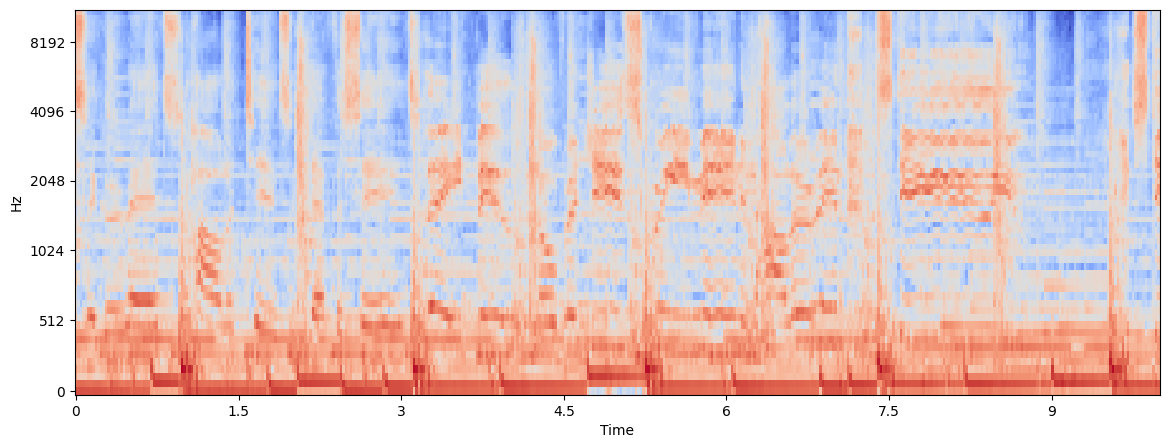

In [152]:
plt.figure(figsize= (14, 5))
librosa.display.specshow(librosa.power_to_db(mel_recuperado), sr=target_sr, hop_length=512, x_axis='time', y_axis='mel')